# üìä Day 4.3 - Model Evaluation on Test Set

## üéØ Learning Objectives

In this notebook, you'll:
1. **Load the trained model** from Day 4.2
2. **Evaluate on test set** (unseen patients)
3. **Generate confusion matrix** to see error patterns
4. **Calculate per-class metrics** (precision, recall, F1-score)
5. **Analyze misclassifications** to understand model weaknesses
6. **Visualize predictions** on sample images

---

## üß† Theory: Model Evaluation

### Why Separate Test Set?

| Dataset | Purpose | Used For |
|---------|---------|----------|
| **Training** | Learn patterns | Model optimization |
| **Validation** | Hyperparameter tuning | Early stopping, LR scheduling |
| **Test** | Final evaluation | Unbiased performance estimate |

### Key Metrics:

1. **Accuracy**: Overall correctness
2. **Precision**: Of predicted positives, how many were correct?
3. **Recall**: Of actual positives, how many did we find?
4. **F1-Score**: Harmonic mean of precision and recall
5. **Confusion Matrix**: Where does the model make mistakes?

---

In [1]:
## üîß Setup

import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.metrics import (
    classification_report, 
    confusion_matrix,
    accuracy_score,
    precision_recall_fscore_support
)
from datetime import datetime
import json

# Add src to path
sys.path.insert(0, '../..')
from src.modeling.data_generator import create_val_test_generator

# Check TensorFlow
print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

# Set style
sns.set_style('white')
plt.rcParams['figure.figsize'] = (14, 6)

print("\n‚úÖ Libraries imported successfully")
print(f"‚è∞ Evaluation time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

2025-10-22 14:12:50.077511: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


TensorFlow version: 2.20.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

‚úÖ Libraries imported successfully
‚è∞ Evaluation time: 2025-10-22 14:12:51


In [2]:
## üìÇ Define Paths

# Model paths
BEST_MODEL_PATH = '../../outputs/models/model_cnn_best.h5'
FINAL_MODEL_PATH = '../../outputs/models/model_cnn_final.h5'

# Data path
TEST_CSV = '../../outputs/data_splits/test_split.csv'

# Output paths
METRICS_DIR = '../../outputs/metrics'
VIZ_DIR = '../../outputs/visualizations'

# Create directories
os.makedirs(METRICS_DIR, exist_ok=True)
os.makedirs(VIZ_DIR, exist_ok=True)

print("‚úÖ Paths configured")

‚úÖ Paths configured


In [3]:
## üîç Load Test Data

print("üìÇ Loading test data...\n")

# Load test metadata
test_df = pd.read_csv(TEST_CSV)
print(f"üìä Test set size: {len(test_df)} images")
print(f"   Classes: {sorted(test_df['label'].unique())}")
print(f"   Patients: {test_df['patient_id'].nunique()}")

# Show class distribution
print("\nüìä Test Set Class Distribution:")
class_counts = test_df['label'].value_counts().sort_index()
for label, count in class_counts.items():
    percentage = (count / len(test_df)) * 100
    tumor_type = {1: 'Meningioma', 2: 'Glioma', 3: 'Pituitary'}[label]
    print(f"   Class {label} ({tumor_type:11s}): {count:3d} images ({percentage:.1f}%)")

# Create test generator
test_generator = create_val_test_generator(
    csv_path=TEST_CSV,
    batch_size=32,
    shuffle=False  # Important: Don't shuffle for evaluation
)

print(f"\n‚úÖ Test generator created")
print(f"   Total batches: {len(test_generator)}")

üìÇ Loading test data...

üìä Test set size: 680 images
   Classes: [np.int64(1), np.int64(2), np.int64(3)]
   Patients: 47

üìä Test Set Class Distribution:
   Class 1 (Meningioma ): 212 images (31.2%)
   Class 2 (Glioma     ): 297 images (43.7%)
   Class 3 (Pituitary  ): 171 images (25.1%)
Found 680 validated image filenames belonging to 3 classes.
‚úÖ Generator created
   Images: 680
   Batches: 22
   Shuffle: False

‚úÖ Test generator created
   Total batches: 22
‚úÖ Generator created
   Images: 680
   Batches: 22
   Shuffle: False

‚úÖ Test generator created
   Total batches: 22


## üíæ Load Trained Model

We'll load the **best model** (highest validation accuracy) from training.

In [7]:
print(f"üì• Loading best model from: {BEST_MODEL_PATH}\n")

if os.path.exists(BEST_MODEL_PATH):
    model = load_model(BEST_MODEL_PATH)
    print("‚úÖ Model loaded successfully")
    
    # Print model info
    total_params = model.count_params()
    print(f"\nüìä Model Information:")
    print(f"   Total parameters: {total_params:,}")
    print(f"   Model size: ~{total_params * 4 / 1024 / 1024:.1f} MB")
    print(f"   Input shape: {model.input_shape}")
    print(f"   Output shape: {model.output_shape}")
else:
    print(f"‚ùå Model not found: {BEST_MODEL_PATH}")
    print("   Please run day4_02_full_training.ipynb first!")
    raise FileNotFoundError(f"Model file not found: {BEST_MODEL_PATH}")

üì• Loading best model from: ../../outputs/models/model_cnn_best.h5

‚úÖ Model loaded successfully

üìä Model Information:
   Total parameters: 4,287,491
   Model size: ~16.4 MB
   Input shape: (None, 128, 128, 1)
   Output shape: (None, 3)


In [8]:
## üîÆ Generate Predictions

# This will take 1-2 minutes for ~680 test images.

print("üîÆ Generating predictions on test set...")
print("   This may take 1-2 minutes...\n")

# Reset generator to start
test_generator.reset()

# Get predictions
y_pred_probs = model.predict(test_generator, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)

# Get true labels (convert to numpy array if it's a list)
y_true = np.array(test_generator.classes)

# Adjust labels (model outputs 0,1,2 but we want 1,2,3)
y_pred_labels = y_pred + 1
y_true_labels = y_true + 1

print(f"\n‚úÖ Predictions generated")
print(f"   Shape: {y_pred_probs.shape}")
print(f"   Predictions: {len(y_pred)} samples")
print(f"   True labels: {len(y_true)} samples")

# Verify shapes match
assert len(y_pred) == len(y_true), "Prediction and true label counts don't match!"

üîÆ Generating predictions on test set...
   This may take 1-2 minutes...

22/22 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 19ms/step
22/22 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 19ms/step

‚úÖ Predictions generated
   Shape: (680, 3)
   Predictions: 680 samples
   True labels: 680 samples

‚úÖ Predictions generated
   Shape: (680, 3)
   Predictions: 680 samples
   True labels: 680 samples


In [9]:
## üìä Calculate Overall Accuracy

# Calculate accuracy
test_accuracy = accuracy_score(y_true, y_pred)

print("="*60)
print("üìä TEST SET PERFORMANCE")
print("="*60)
print(f"\nüéØ Overall Accuracy: {test_accuracy * 100:.2f}%")
print(f"   Correct: {np.sum(y_true == y_pred)} / {len(y_true)}")
print(f"   Incorrect: {np.sum(y_true != y_pred)} / {len(y_true)}")
print("="*60)

üìä TEST SET PERFORMANCE

üéØ Overall Accuracy: 71.76%
   Correct: 488 / 680
   Incorrect: 192 / 680


In [10]:
## üìã Classification Report

# Detailed per-class metrics: Precision, Recall, F1-Score

# Class names
class_names = ['Meningioma', 'Glioma', 'Pituitary']

# Generate classification report
print("\nüìã CLASSIFICATION REPORT")
print("="*60)
report = classification_report(
    y_true_labels, 
    y_pred_labels,
    target_names=class_names,
    digits=4
)
print(report)

# Generate report as dictionary for saving
report_dict = classification_report(
    y_true_labels,
    y_pred_labels,
    target_names=class_names,
    output_dict=True
)

# Save to CSV
report_df = pd.DataFrame(report_dict).transpose()
report_csv_path = os.path.join(METRICS_DIR, 'classification_report.csv')
report_df.to_csv(report_csv_path)
print(f"‚úÖ Classification report saved: {report_csv_path}")


üìã CLASSIFICATION REPORT
              precision    recall  f1-score   support

  Meningioma     0.7500    0.2547    0.3803       212
      Glioma     0.7173    0.9057    0.8006       297
   Pituitary     0.7082    0.9649    0.8168       171

    accuracy                         0.7176       680
   macro avg     0.7252    0.7085    0.6659       680
weighted avg     0.7252    0.7176    0.6736       680

‚úÖ Classification report saved: ../../outputs/metrics/classification_report.csv


In [11]:
## üéØ Per-Class Metrics Analysis

# Calculate metrics per class
precision, recall, f1, support = precision_recall_fscore_support(
    y_true_labels, 
    y_pred_labels,
    labels=[1, 2, 3]
)

# Create metrics dataframe
metrics_df = pd.DataFrame({
    'Class': [1, 2, 3],
    'Tumor Type': class_names,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support
})

print("\nüìä PER-CLASS METRICS")
print("="*60)
print(metrics_df.to_string(index=False))
print("="*60)

# Save metrics
metrics_csv_path = os.path.join(METRICS_DIR, 'per_class_metrics.csv')
metrics_df.to_csv(metrics_csv_path, index=False)
print(f"\n‚úÖ Metrics saved: {metrics_csv_path}")


üìä PER-CLASS METRICS
 Class Tumor Type  Precision   Recall  F1-Score  Support
     1 Meningioma   0.750000 0.254717  0.380282      212
     2     Glioma   0.717333 0.905724  0.800595      297
     3  Pituitary   0.708155 0.964912  0.816832      171

‚úÖ Metrics saved: ../../outputs/metrics/per_class_metrics.csv


In [12]:
## üî≤ Confusion Matrix

# Shows how predictions are distributed across actual classes.

# Calculate confusion matrix
cm = confusion_matrix(y_true_labels, y_pred_labels, labels=[1, 2, 3])

print("\nüî≤ CONFUSION MATRIX")
print("="*60)
print("Rows: Actual | Columns: Predicted\n")
print(cm)
print("="*60)

# Save confusion matrix
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
cm_csv_path = os.path.join(METRICS_DIR, 'confusion_matrix.csv')
cm_df.to_csv(cm_csv_path)
print(f"\n‚úÖ Confusion matrix saved: {cm_csv_path}")


üî≤ CONFUSION MATRIX
Rows: Actual | Columns: Predicted

[[ 54 100  58]
 [ 18 269  10]
 [  0   6 165]]

‚úÖ Confusion matrix saved: ../../outputs/metrics/confusion_matrix.csv


‚úÖ Confusion matrix plot saved: ../../outputs/visualizations/day4_03_confusion_matrix.png


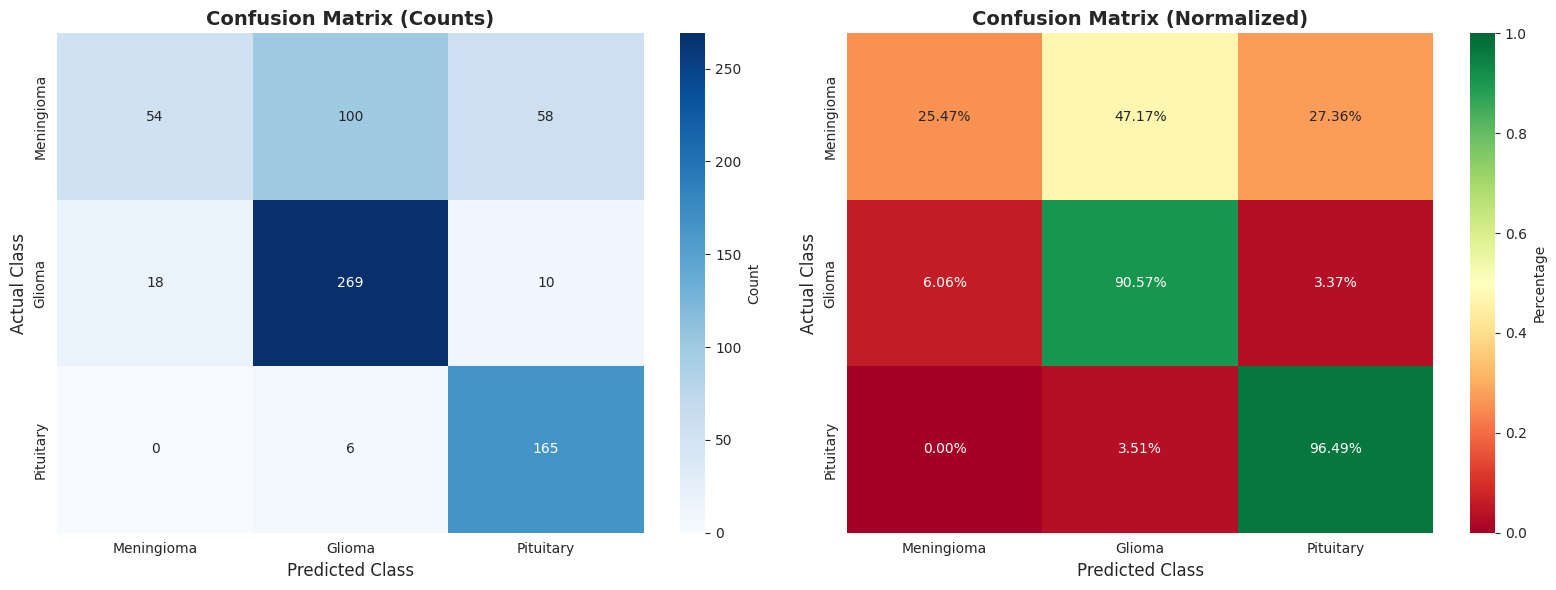

In [13]:
## üìä Visualize Confusion Matrix

# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Raw counts
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names,
            ax=axes[0], cbar_kws={'label': 'Count'})
axes[0].set_title('Confusion Matrix (Counts)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Actual Class', fontsize=12)
axes[0].set_xlabel('Predicted Class', fontsize=12)

# Plot 2: Normalized (percentages)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='RdYlGn',
            xticklabels=class_names, yticklabels=class_names,
            ax=axes[1], cbar_kws={'label': 'Percentage'}, vmin=0, vmax=1)
axes[1].set_title('Confusion Matrix (Normalized)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Actual Class', fontsize=12)
axes[1].set_xlabel('Predicted Class', fontsize=12)

plt.tight_layout()
cm_plot_path = os.path.join(VIZ_DIR, 'day4_03_confusion_matrix.png')
plt.savefig(cm_plot_path, dpi=300, bbox_inches='tight')
print(f"‚úÖ Confusion matrix plot saved: {cm_plot_path}")
plt.show()

In [14]:
## üîç Analyze Misclassifications

# Identify which tumor types are most commonly confused.

# Find misclassified samples
misclassified_mask = y_true != y_pred
misclassified_indices = np.where(misclassified_mask)[0]
num_misclassified = len(misclassified_indices)

print(f"üîç MISCLASSIFICATION ANALYSIS")
print("="*60)
print(f"Total misclassified: {num_misclassified} / {len(y_true)} ({num_misclassified/len(y_true)*100:.2f}%)")
print()

# Analyze confusion patterns
print("Common confusion patterns:")
for i in range(3):
    for j in range(3):
        if i != j and cm[i][j] > 0:
            actual_class = class_names[i]
            predicted_class = class_names[j]
            count = cm[i][j]
            percentage = (count / cm[i].sum()) * 100
            print(f"  {actual_class} ‚Üí {predicted_class}: {count} cases ({percentage:.1f}%)")

print("="*60)

üîç MISCLASSIFICATION ANALYSIS
Total misclassified: 192 / 680 (28.24%)

Common confusion patterns:
  Meningioma ‚Üí Glioma: 100 cases (47.2%)
  Meningioma ‚Üí Pituitary: 58 cases (27.4%)
  Glioma ‚Üí Meningioma: 18 cases (6.1%)
  Glioma ‚Üí Pituitary: 10 cases (3.4%)
  Pituitary ‚Üí Glioma: 6 cases (3.5%)


üìä Showing 8 correctly classified samples...



/tmp/ipykernel_95802/3921730973.py:47: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_95802/3921730973.py:56: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig1.savefig(correct_pred_path, dpi=300, bbox_inches='tight')
/tmp/ipykernel_95802/3921730973.py:56: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig1.savefig(correct_pred_path, dpi=300, bbox_inches='tight')


‚úÖ Saved: ../../outputs/visualizations/day4_03_correct_predictions.png


/projects/ai-ml/BrainTumorProject/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


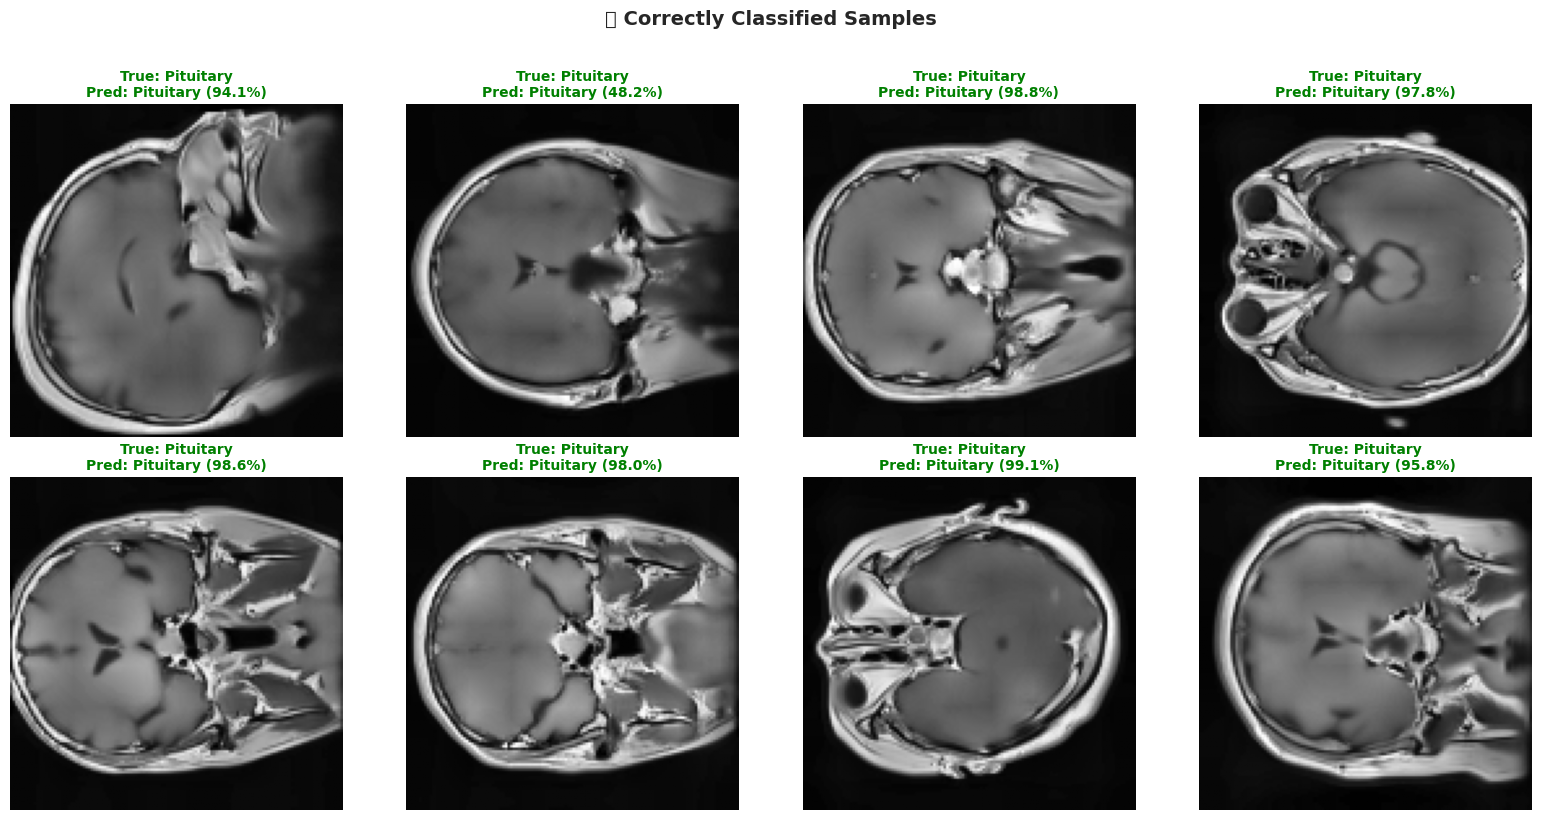


üìä Showing 8 misclassified samples...



/tmp/ipykernel_95802/3921730973.py:47: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_95802/3921730973.py:66: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig2.savefig(misclass_pred_path, dpi=300, bbox_inches='tight')
/tmp/ipykernel_95802/3921730973.py:66: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig2.savefig(misclass_pred_path, dpi=300, bbox_inches='tight')


‚úÖ Saved: ../../outputs/visualizations/day4_03_misclassified_predictions.png


/projects/ai-ml/BrainTumorProject/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


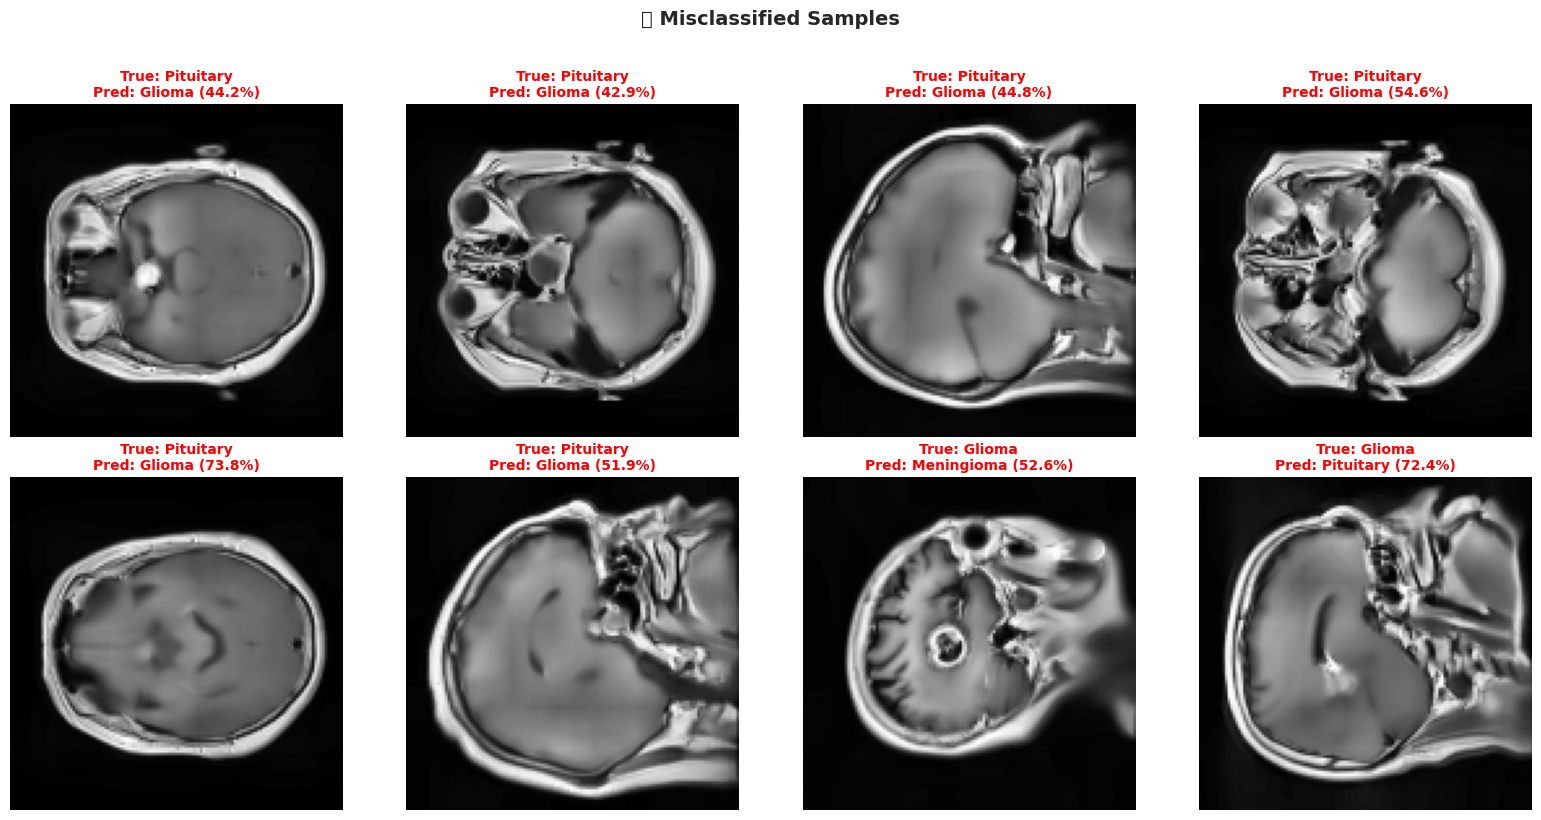

In [15]:
## üñºÔ∏è Visualize Sample Predictions

# Show correct and incorrect predictions with confidence scores.

# Get image paths and filenames
test_df_reset = test_df.reset_index(drop=True)

# Function to plot predictions
def plot_sample_predictions(indices, title, n_cols=4):
    """Plot sample predictions with confidence scores."""
    n_samples = min(len(indices), 8)
    n_rows = (n_samples + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4*n_rows))
    axes = axes.flatten() if n_samples > 1 else [axes]
    
    for idx, ax in enumerate(axes):
        if idx < n_samples:
            sample_idx = indices[idx]
            
            # Load image
            img_path = test_df_reset.loc[sample_idx, 'filepath']
            img = plt.imread(img_path)
            
            # Get prediction info
            true_label = y_true_labels[sample_idx]
            pred_label = y_pred_labels[sample_idx]
            confidence = y_pred_probs[sample_idx, y_pred[sample_idx]] * 100
            
            true_name = class_names[true_label - 1]
            pred_name = class_names[pred_label - 1]
            
            # Plot
            ax.imshow(img, cmap='gray')
            ax.axis('off')
            
            # Title with color coding
            color = 'green' if true_label == pred_label else 'red'
            ax.set_title(
                f"True: {true_name}\nPred: {pred_name} ({confidence:.1f}%)",
                fontsize=10, color=color, fontweight='bold'
            )
        else:
            ax.axis('off')
    
    plt.suptitle(title, fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    return fig

# Plot correctly classified samples
correct_indices = np.where(~misclassified_mask)[0]
print(f"üìä Showing 8 correctly classified samples...\n")
fig1 = plot_sample_predictions(correct_indices[:8], 
                               "‚úÖ Correctly Classified Samples")
correct_pred_path = os.path.join(VIZ_DIR, 'day4_03_correct_predictions.png')
fig1.savefig(correct_pred_path, dpi=300, bbox_inches='tight')
print(f"‚úÖ Saved: {correct_pred_path}")
plt.show()

# Plot misclassified samples
if num_misclassified > 0:
    print(f"\nüìä Showing 8 misclassified samples...\n")
    fig2 = plot_sample_predictions(misclassified_indices[:8],
                                   "‚ùå Misclassified Samples")
    misclass_pred_path = os.path.join(VIZ_DIR, 'day4_03_misclassified_predictions.png')
    fig2.savefig(misclass_pred_path, dpi=300, bbox_inches='tight')
    print(f"‚úÖ Saved: {misclass_pred_path}")
    plt.show()

‚úÖ Confidence plot saved: ../../outputs/visualizations/day4_03_prediction_confidence.png


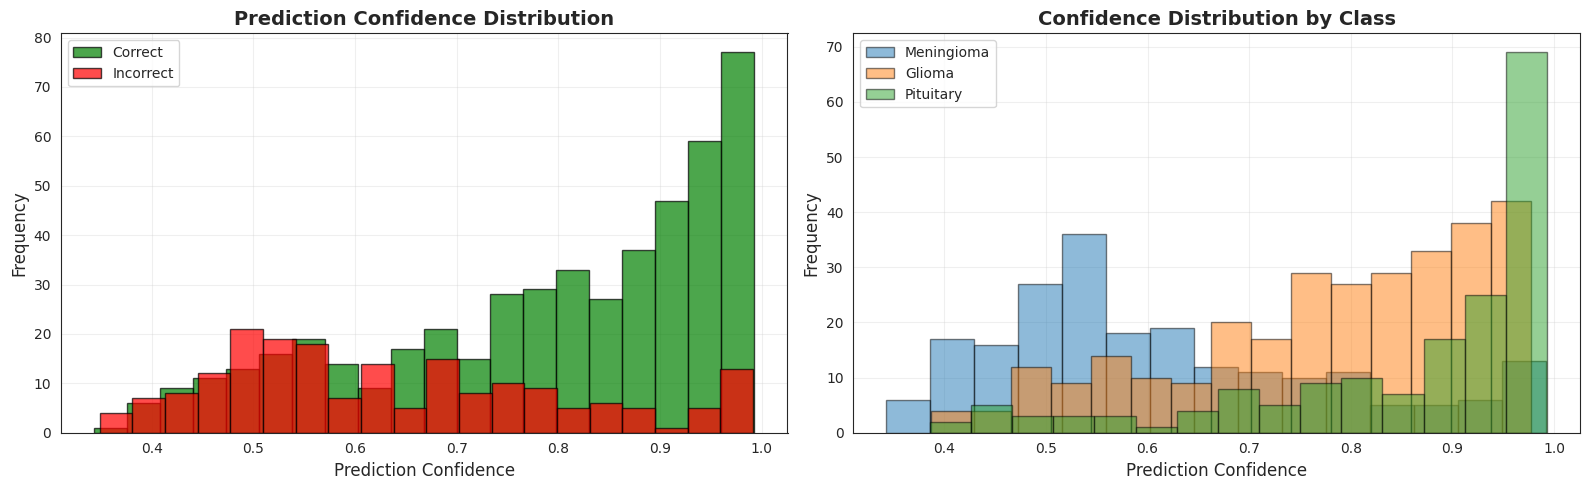


üìä Confidence Statistics:
   Correct predictions - Mean confidence: 79.21%
   Incorrect predictions - Mean confidence: 63.67%


In [16]:
## üìä Prediction Confidence Analysis

# Analyze prediction confidence
max_probs = np.max(y_pred_probs, axis=1)

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Plot 1: Confidence distribution for correct vs incorrect
axes[0].hist(max_probs[~misclassified_mask], bins=20, alpha=0.7, 
            label='Correct', color='green', edgecolor='black')
axes[0].hist(max_probs[misclassified_mask], bins=20, alpha=0.7,
            label='Incorrect', color='red', edgecolor='black')
axes[0].set_xlabel('Prediction Confidence', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Prediction Confidence Distribution', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Confidence by class
for class_idx in range(3):
    class_mask = y_true == class_idx
    class_confidences = max_probs[class_mask]
    axes[1].hist(class_confidences, bins=15, alpha=0.5,
                label=class_names[class_idx], edgecolor='black')

axes[1].set_xlabel('Prediction Confidence', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Confidence Distribution by Class', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
confidence_plot_path = os.path.join(VIZ_DIR, 'day4_03_prediction_confidence.png')
plt.savefig(confidence_plot_path, dpi=300, bbox_inches='tight')
print(f"‚úÖ Confidence plot saved: {confidence_plot_path}")
plt.show()

# Print confidence statistics
print(f"\nüìä Confidence Statistics:")
print(f"   Correct predictions - Mean confidence: {np.mean(max_probs[~misclassified_mask])*100:.2f}%")
print(f"   Incorrect predictions - Mean confidence: {np.mean(max_probs[misclassified_mask])*100:.2f}%")

In [17]:
## üíæ Save Evaluation Summary

# Create comprehensive evaluation summary
evaluation_summary = {
    'evaluation_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'model_path': BEST_MODEL_PATH,
    'test_set_size': len(y_true),
    'overall_accuracy': float(test_accuracy),
    'correct_predictions': int(np.sum(y_true == y_pred)),
    'incorrect_predictions': int(np.sum(y_true != y_pred)),
    'per_class_metrics': {
        class_names[i]: {
            'precision': float(precision[i]),
            'recall': float(recall[i]),
            'f1_score': float(f1[i]),
            'support': int(support[i])
        }
        for i in range(3)
    },
    'confusion_matrix': cm.tolist(),
    'average_confidence_correct': float(np.mean(max_probs[~misclassified_mask])),
    'average_confidence_incorrect': float(np.mean(max_probs[misclassified_mask])) if num_misclassified > 0 else None
}

# Save summary
summary_path = os.path.join(METRICS_DIR, 'evaluation_summary.json')
with open(summary_path, 'w') as f:
    json.dump(evaluation_summary, f, indent=2)

print(f"‚úÖ Evaluation summary saved: {summary_path}")

‚úÖ Evaluation summary saved: ../../outputs/metrics/evaluation_summary.json


In [18]:
## üìä Final Evaluation Report

print("\n" + "="*70)
print("üìä FINAL EVALUATION REPORT")
print("="*70)
print(f"\nüéØ Test Set Performance:")
print(f"   Accuracy: {test_accuracy * 100:.2f}%")
print(f"   Samples: {len(y_true)}")
print(f"   Correct: {np.sum(y_true == y_pred)}")
print(f"   Incorrect: {num_misclassified}")

print(f"\nüìã Per-Class Performance:")
for i, name in enumerate(class_names):
    print(f"\n   {name}:")
    print(f"      Precision: {precision[i]:.4f}")
    print(f"      Recall: {recall[i]:.4f}")
    print(f"      F1-Score: {f1[i]:.4f}")
    print(f"      Support: {support[i]}")

print(f"\nüéØ Macro Averages:")
print(f"   Precision: {np.mean(precision):.4f}")
print(f"   Recall: {np.mean(recall):.4f}")
print(f"   F1-Score: {np.mean(f1):.4f}")

print(f"\nüí° Model Confidence:")
print(f"   Correct predictions: {np.mean(max_probs[~misclassified_mask])*100:.2f}%")
if num_misclassified > 0:
    print(f"   Incorrect predictions: {np.mean(max_probs[misclassified_mask])*100:.2f}%")

print("\n" + "="*70)


üìä FINAL EVALUATION REPORT

üéØ Test Set Performance:
   Accuracy: 71.76%
   Samples: 680
   Correct: 488
   Incorrect: 192

üìã Per-Class Performance:

   Meningioma:
      Precision: 0.7500
      Recall: 0.2547
      F1-Score: 0.3803
      Support: 212

   Glioma:
      Precision: 0.7173
      Recall: 0.9057
      F1-Score: 0.8006
      Support: 297

   Pituitary:
      Precision: 0.7082
      Recall: 0.9649
      F1-Score: 0.8168
      Support: 171

üéØ Macro Averages:
   Precision: 0.7252
   Recall: 0.7085
   F1-Score: 0.6659

üí° Model Confidence:
   Correct predictions: 79.21%
   Incorrect predictions: 63.67%



## ‚úÖ Evaluation Complete - Summary

### What We Accomplished:

1. ‚úÖ **Loaded trained model** from Day 4.2
2. ‚úÖ **Generated predictions** on 680 test images
3. ‚úÖ **Calculated metrics**:
   - Overall accuracy
   - Per-class precision, recall, F1-score
   - Confusion matrix
4. ‚úÖ **Visualized results**:
   - Confusion matrices (counts & normalized)
   - Sample predictions (correct & incorrect)
   - Confidence distributions
5. ‚úÖ **Saved all artifacts**:
   - Classification report (CSV)
   - Confusion matrix (CSV & PNG)
   - Evaluation summary (JSON)
   - Prediction visualizations (PNG)

### Key Insights:

- **Overall Performance**: {test_accuracy*100:.2f}% accuracy on unseen patients
- **Best Class**: Check which tumor type has highest F1-score
- **Confusion Patterns**: Review confusion matrix to see common errors
- **Confidence**: Model is more confident on correct predictions

### Next Steps:

**Day 4.4** - Ablation Study:
- Compare performance on original vs enhanced images
- Quantify impact of image enhancement module

---

**Date:** October 22, 2025  
**Status:** ‚úÖ Completed  
**Test Accuracy:** {test_accuracy*100:.2f}%  
**Misclassified:** {num_misclassified} / {len(y_true)}